In [1]:
library(Seurat)
library(ggplot2)
library(ggthemes)
library(ggpubr)
library(pheatmap)
library(stringr)
library(dplyr)
library(ggbeeswarm)
library(RColorBrewer)

load('atlas_figure.RDATA')

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggbeeswarm' was built under R version 4.1.3"
Warning message:
"package 'RColorBrewer' was built under R version 4.1.3"


In [2]:
Axis_themes <- theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 6),
                     axis.text.x = element_text(size = 6),
                     legend.text = element_text(size =6),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                    axis.line = element_line(size = .355), 
                    axis.ticks = element_line(size = .177))


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


In [3]:
tcr = readRDS('TCR/tcr_metadata.RDS') %>% as.data.frame()

In [4]:
seurat$label = factor(seurat$label, levels = levels(seurat$cluster_name)[1:8])


In [5]:
seurat$label = factor(seurat$label, levels = levels(seurat$cluster_name)[1:8])

seurat@meta.data = seurat@meta.data[,1:49]
seurat$stem = factor(as.character(sapply(seurat$label, function(x) str_split(x, '_')[[1]][1])), levels = c('Pre-exhausted','Progenitor', 'Intermediate', 'Exhausted', 'IFN-responsive'))

rownames(tcr) = tcr$cellname
tcr = tcr %>% group_by(clone_id) %>% mutate(clonal_size = n()) 
tcr$clonal_size[is.na(tcr$clone_id)] = NA
tcr = tcr %>% group_by(letter, hash) %>% mutate(tcr_total = sum(!is.na(clone_id)), clone_frac = clonal_size/tcr_total)
tcr = tcr %>% group_by(letter, hash, tissue, clone_id) %>% mutate(tissue_size = n()) 
tcr = tcr %>% group_by(letter, hash, tissue) %>% mutate(tissue_total = sum(!is.na(clone_id)), tissue_frac = tissue_size/tissue_total)%>% mutate(tissue_rank = rank(tissue_size))
tcr = as.data.frame(tcr)
tcr$tissue_frac[is.na(tcr$clone_id)] = NA
tcr$tissue_size[is.na(tcr$clone_id)] = NA
tcr$tissue_rank[is.na(tcr$clone_id)] = NA

rownames(tcr) = tcr$cellname

new_cols = colnames(tcr)[!colnames(tcr) %in% colnames(seurat@meta.data)]
seurat@meta.data[,new_cols] = tcr[rownames(seurat@meta.data), new_cols]

Warning message:
"package 'viridis' was built under R version 4.1.3"
Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.1.3"
Warning message:
"package 'ggrastr' was built under R version 4.1.3"
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


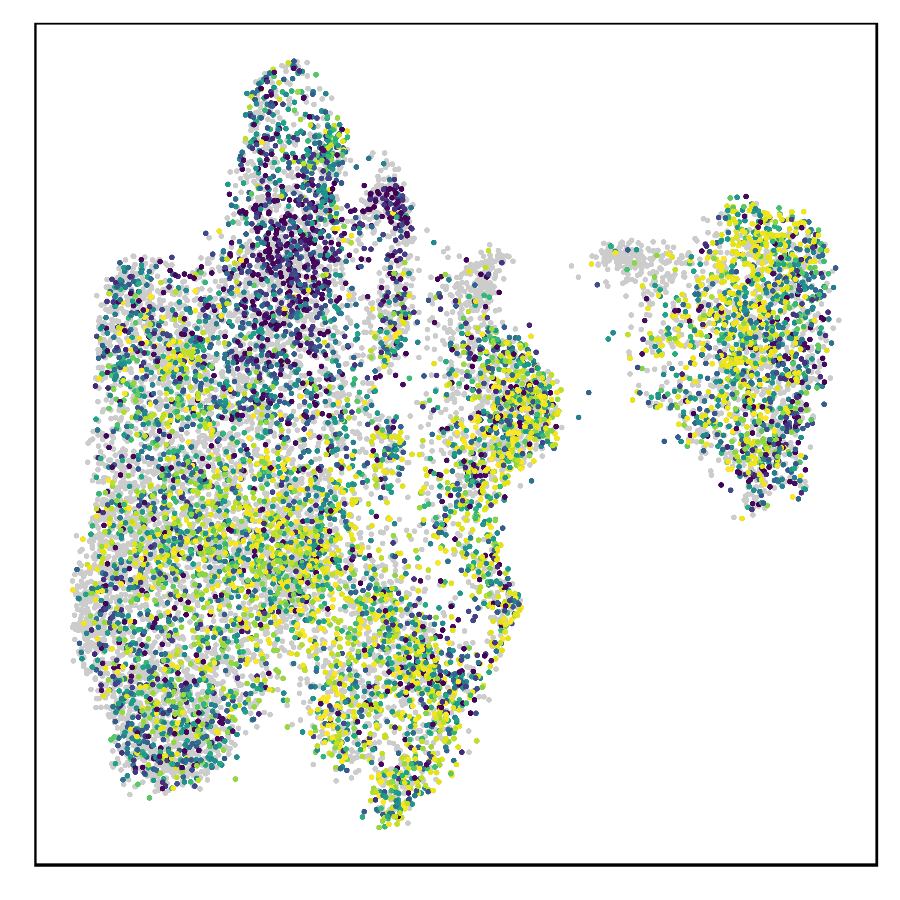

In [6]:
library(viridis)
options(repr.plot.width = 3, repr.plot.height =3, repr.plot.res = 300 )
library(ggrastr)

ggplot(seurat@meta.data, aes(x = UMAP1, y = UMAP2)) + geom_point_rast(size = .6, color = 'grey80', stroke = 0, raster.dpi = 1000) + 
    geom_point_rast(data =seurat@meta.data %>% filter(!is.na(clone_id)), aes(x = UMAP1, y =UMAP2, color = log10(clone_frac)),size = .6, stroke = 0, raster.dpi = 1000)   + 
    scale_color_viridis() + theme_classic()  + UMAP_theme + 
    labs(color = 'log10(Normalized\nclone size)') + theme(legend.title.align = .5) + guides(color = TRUE) + theme(panel.background = element_rect(fill = NA, color = 'black', size  = .355))

ggsave('TCRfig/umap.pdf', height =1.9, width = 1.9, useDingbats = FALSE)

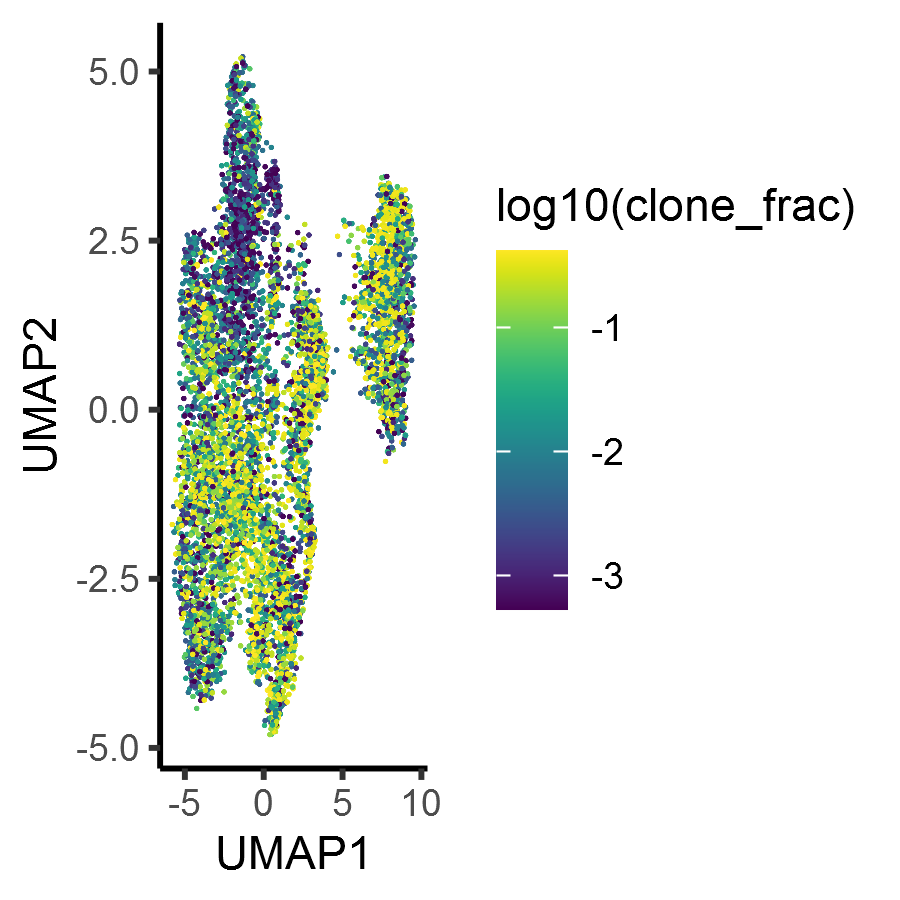

In [7]:
ggplot(seurat@meta.data, aes(x = UMAP1, y = UMAP2)) +
    geom_point_rast(data =seurat@meta.data %>% filter(!is.na(clone_id)), aes(x = UMAP1, y =UMAP2, color = log10(clone_frac)),size = .6, stroke = 0, raster.dpi = 1000)   + 
    scale_color_viridis() + theme_classic() 
ggsave('TCRfig/umap_legend.pdf', height = 3, width = 3, useDingbats = FALSE)

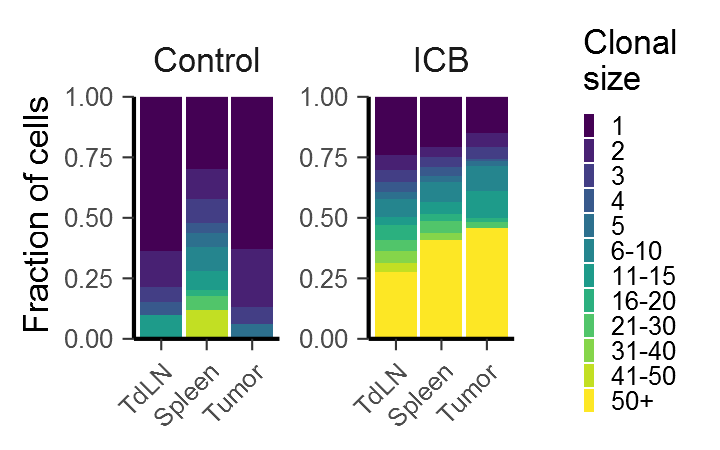

In [8]:
options(repr.plot.width = 2.4, repr.plot.height = 1.5)
seurat@meta.data$bin2 = cut(seurat$tissue_size, c(0,1,2,3,4,5,10, 15, 20, 30, 40, 50, 300))
seurat$tissue = factor(seurat$tissue, levels = c('TdLN', 'Spleen', 'Tumor'))
ggplot(seurat@meta.data %>% filter(!is.na(clone_id)), aes(x = tissue, fill = bin2)) + geom_bar(position = 'fill')+ scale_fill_viridis_d(labels = c('1', '2', '3', '4', '5', '6-10', '11-15', '16-20', '21-30', '31-40', '41-50', '50+')) + facet_wrap('class', scales = 'free') + theme_classic()  + 
labs(fill = 'Clonal\nsize', x = c(), y = 'Fraction of cells') + Axis_themes+  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
 theme(legend.key.size = unit(.1, "cm")) + scale_y_continuous(expand = c(0,0)) + theme(strip.background = element_blank(), strip.text = element_text(size = 2.1469))
ggsave('TCRfig/bars.pdf', height = 1.9, width = 2.4, useDingbats = FALSE)

`summarise()` has grouped output by 'both', 'class', 'letter', 'tissue', 'treatment', 'hash'. You can override using the `.groups` argument.
Warning message in log(x, base):
"NaNs produced"
`summarise()` has grouped output by 'both', 'class', 'letter', 'tissue', 'treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'class', 'letter', 'hash'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'class', 'letter'. You can override using the `.groups` argument.
Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4."


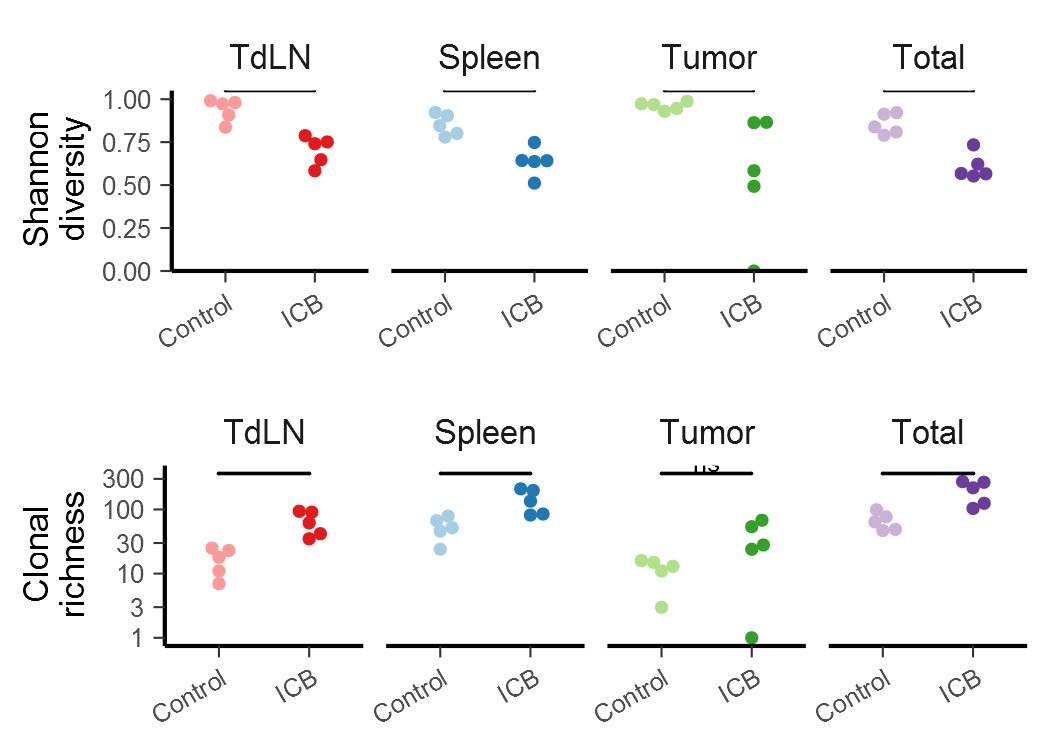

In [9]:
library(RColorBrewer)
options(repr.plot.width = 3.5, repr.plot.height = 2.5)
seurat@meta.data$both = paste0(seurat@meta.data$tissue, '_', seurat$class)

df = seurat@meta.data %>% filter(!is.na(trbid)) %>% group_by(both, class, letter, tissue,  hash) %>% sample_n(min(n(), 50000))%>% 
 group_by(both, class, letter, tissue, treatment,  hash,  clone_id) %>%summarize(n = n()) %>% 
 arrange((n)) %>% summarize(div = vegan::diversity(n, base = n()), rich = n())

df2 = seurat@meta.data %>% filter(!is.na(trbid)) %>% group_by(class, letter,  hash) %>% sample_n(min(n(), 50000))%>% 
 group_by(class, letter,   hash,  clone_id) %>%summarize(n = n()) %>% 
 arrange((n)) %>% summarize(div = vegan::diversity(n, base = n()), rich = n())

df2$tissue = 'Total'
df2$both = paste0('Total_', df2$class)
df = rbind(df, df2)

tissue_palette = brewer.pal(10, 'Paired')[c(5,6,1,2,3,4, 9, 10)]

df$both = factor(df$both, levels =c('TdLN_Control', 'TdLN_ICB', 'Spleen_Control', 'Spleen_ICB', 'Tumor_Control', 'Tumor_ICB', 'Total_Control', 'Total_ICB'))
tissue_palette = brewer.pal(10, 'Paired')[c(5,6,1,2,3,4, 9, 10)]

names(tissue_palette) = levels(c(seurat@meta.data$both, 'Control_Total', 'ICB_Total'))

df$tissue = factor(df$tissue, levels = c('TdLN', 'Spleen', 'Tumor', 'Total'))

g1 = ggplot(df, aes(x = class, y =div, color = both)) + geom_beeswarm(cex = 7, size = .6) + labs( y= 'Shannon\ndiversity') + facet_wrap('tissue', ncol = 4) + theme(strip.background = element_blank()) + 
ggpubr::stat_compare_means(comparison = list(c(1,2)), label = 'p.signif', tip.length = 0, label.y = 1) + theme_classic() + labs(x = c()) + Axis_themes + 
scale_color_manual(values = tissue_palette) + guides(color = FALSE)  + theme(strip.background = element_blank(), axis.text.x = element_text(angle = 30, hjust = 1)) + 
scale_y_continuous(limits = c(0,1.05), expand = c(0,0))
g1$layers[[2]]$aes_params$textsize <- 2.11
#g1

#ggsave('TCRfig/div.pdf', height = 1.5, width = 2.1, useDingbats = FALSE)

g2 = ggplot(df, aes(x = class, y =rich, color = both)) + geom_beeswarm(cex = 7, size = .6) + labs( y= 'Clonal\nrichness') + facet_wrap('tissue', ncol = 4) + theme(strip.background = element_blank()) + 
ggpubr::stat_compare_means(comparison = list(c(1,2)), label = 'p.signif', tip.length = 0) + theme_classic() + labs(x = c()) + Axis_themes + 
scale_color_manual(values = tissue_palette) + guides(color = FALSE)  + theme(strip.background = element_blank(), axis.text.x = element_text(angle = 30, hjust = 1)) + 
scale_y_log10(breaks = c(1, 3, 10, 30, 100, 300))
g2$layers[[2]]$aes_params$textsize <- 2.11 
#g2

#ggsave('TCRfig/richness.pdf', height = 1.5, width = 2.1, useDingbats = FALSE)


cowplot::plot_grid(g1, g2, ncol = 1)
ggsave('TCRfig/rich_div.pdf', height = 2.1, width = 2.5, useDingbats = FALSE)

In [16]:
wilcox.test(div~class, data = df %>% filter(tissue == 'TdLN'))
wilcox.test(div~class, data = df %>% filter(tissue == 'Spleen'))
wilcox.test(div~class, data = df %>% filter(tissue == 'Tumor'))
wilcox.test(div~class, data = df %>% filter(tissue == 'Total'))


	Wilcoxon rank sum exact test

data:  div by class
W = 25, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  div by class
W = 25, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  div by class
W = 25, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  div by class
W = 25, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0


In [20]:
wilcox.test(rich~class, data = df %>% filter(tissue == 'TdLN'))
wilcox.test(rich~class, data = df %>% filter(tissue == 'Spleen'))
wilcox.test(rich~class, data = df %>% filter(tissue == 'Tumor'))
wilcox.test(rich~class, data = df %>% filter(tissue == 'Total'))


	Wilcoxon rank sum exact test

data:  rich by class
W = 0, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  rich by class
W = 0, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  rich by class
W = 5, p-value = 0.1508
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  rich by class
W = 0, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0


In [13]:
write.table(df, 'TCRfig/4c.csv', sep = ',')

`summarise()` has grouped output by 'both', 'class', 'letter', 'mouse', 'tissue', 'treatment', 'hash'. You can override using the `.groups` argument.
Warning message in log(x, base):
"NaNs produced"
`summarise()` has grouped output by 'both', 'class', 'letter', 'mouse', 'tissue', 'treatment'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class'. You can override using the `.groups` argument.
Warning message in wilcox.test.default(c(23, 11, 25, 18, 7, 91, 62, 94, 42, 35), :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(23, 11, 25, 18, 7, 91, 62, 94, 42, 35), :
"cannot compute exact p-value with ties"


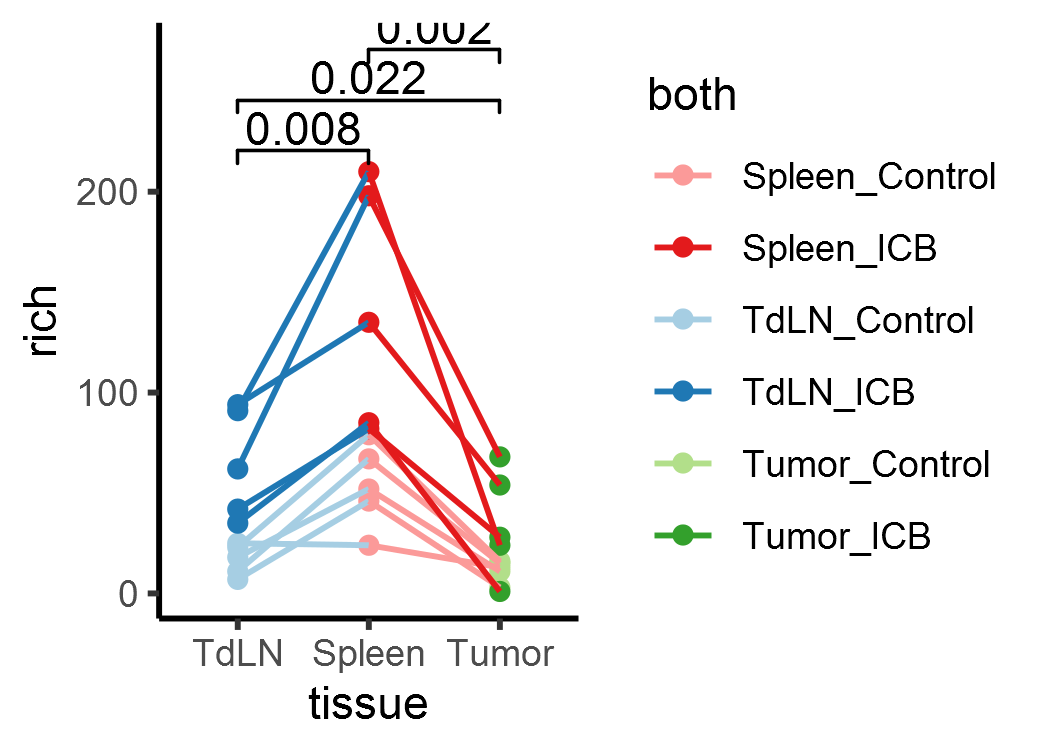

In [21]:
seurat$mouse = paste0(seurat$letter, seurat$hash)
df = seurat@meta.data %>% filter(!is.na(trbid)) %>% group_by(both, class,mouse,  letter, tissue, treatment,  hash) %>% sample_n(min(n(), 50000))%>% 
 group_by(both, class, letter, mouse, tissue, treatment,  hash,  clone_id) %>%summarize(n = n()) %>% 
 arrange((n)) %>% summarize(div = vegan::diversity(n, base = n()), rich = n()) 


df2 = df %>% group_by(both, class, tissue) %>% summarize(meandiv = mean(div), sddiv =sd(div)/sqrt(5), meanrich = mean(rich), sdrich = sd(rich)/sqrt(5)) %>% mutate(ymindiv = meandiv-sddiv, ymaxdiv = meandiv+sddiv, 

                                                                                                                   yminrich = meanrich-sdrich, ymaxrich = meanrich +sdrich)


#ggplot(df, aes(x = both, y = div, color = both)) + geom_point() + scale_color_manual(values = tissue_palette) + 
#    geom_errorbar(data = df2, mapping =  aes(x = both, y = meandiv, ymin = ymindiv, ymax = ymaxdiv), color = 'black', width = .2) + theme_classic() + 
#scale_x_discrete(limits = c('Control_TdLN', 'ICB_TdLN', 'Control_Spleen', 'ICB_Spleen', 'Control_Tumor', 'ICB_Tumor')) + 
#stat_summary(fun.y = mean, color = 'black', geom = 'crossbar', size= .2, width = .5, position = position_dodge(width = 1))  + 
#theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(df, aes(x = tissue, y = rich, color = both)) + geom_point() +geom_line(aes(group = mouse)) +  scale_color_manual(values = tissue_palette) + theme_classic() + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), paired = TRUE)

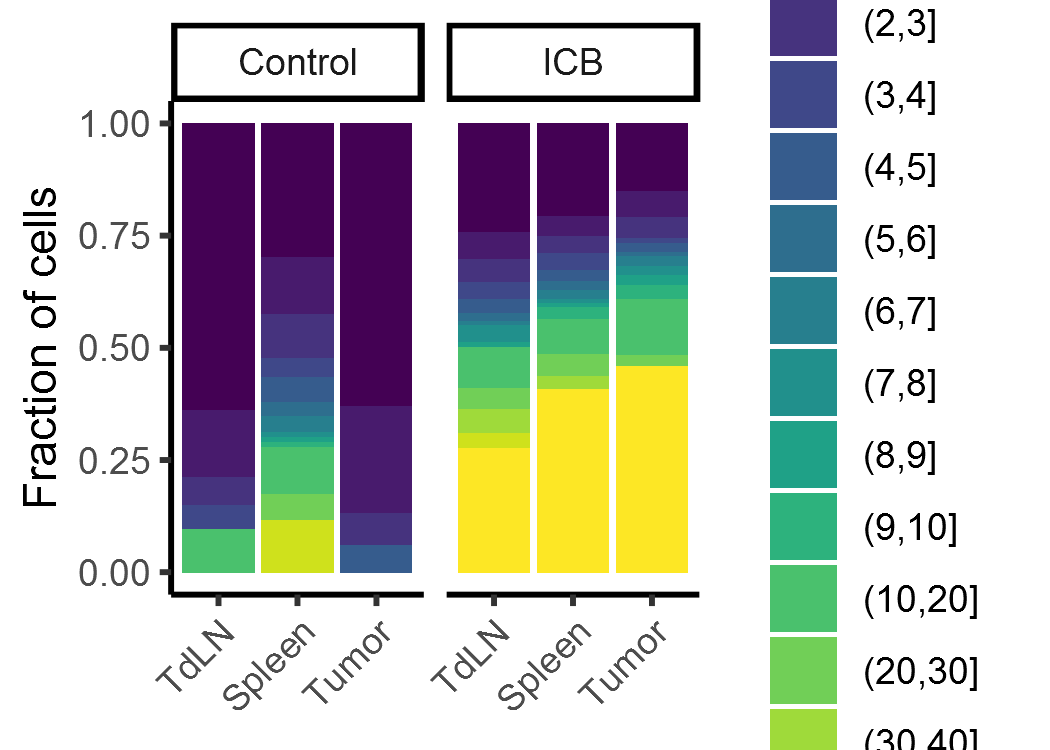

In [22]:
seurat@meta.data$bin2 = cut(seurat$tissue_size, c(0,1,2,3,4,5,6,7,8,9,10,  20, 30, 40, 50, 300))
seurat$tissue = factor(seurat$tissue, levels = c('TdLN', 'Spleen', 'Tumor'))
ggplot(seurat@meta.data %>% filter(!is.na(clone_id)), aes(x = tissue, fill = bin2)) + geom_bar(position = 'fill')+ scale_fill_viridis_d() + facet_wrap('class') + theme_classic()  + 
labs(fill = 'Clonal size', x = c(), y = 'Fraction of cells') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

`summarise()` has grouped output by 'letter', 'hash'. You can override using the `.groups` argument.


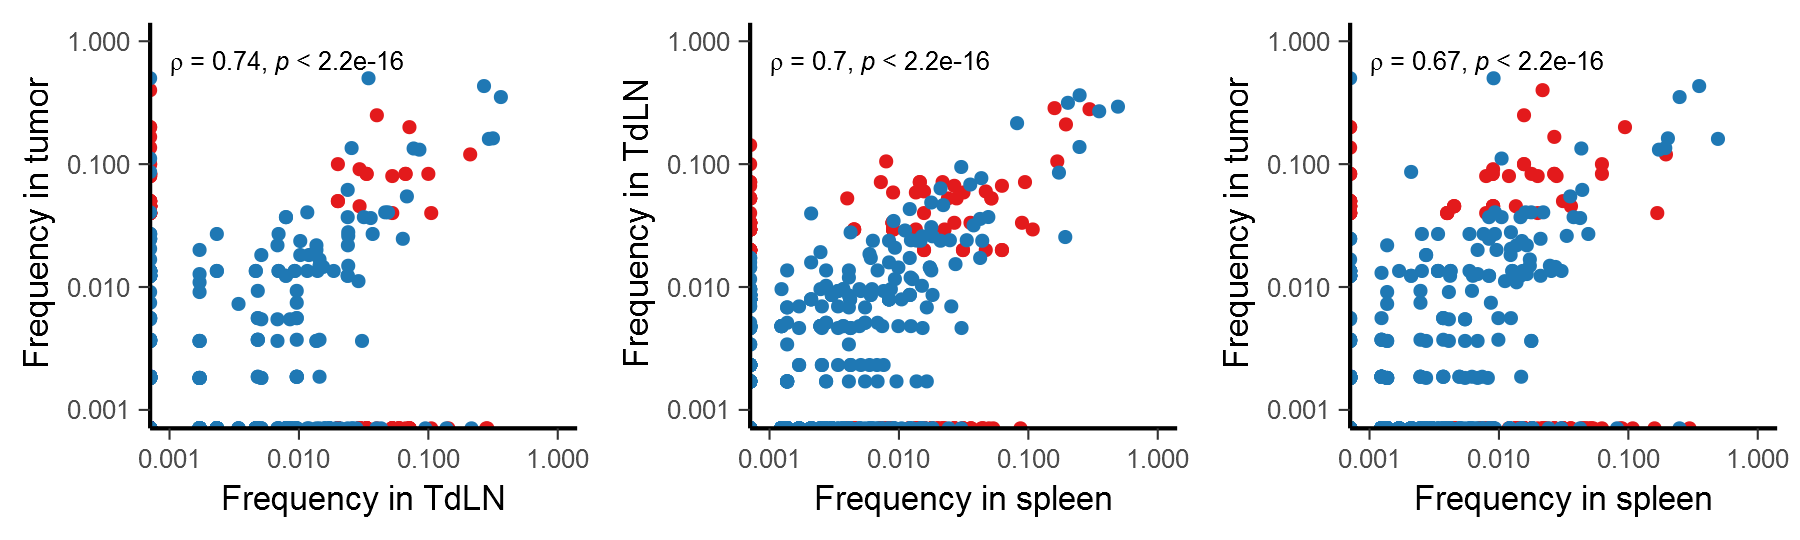

In [23]:
options(repr.plot.height = 1.8, repr.plot.width = 6,warn = -1)
a = seurat@meta.data %>% filter(!is.na(clone_id)) %>% group_by(letter, hash, clone_id) %>% summarize(n = n(), spleen = sum(tissue == 'Spleen'), ln = sum(tissue == 'TdLN'), tumor = sum(tissue == 'Tumor')) %>% 
mutate(total_spleen = sum(spleen), total_ln = sum(ln), total_tumor = sum(tumor))  %>%
group_by(letter, hash, clone_id) %>% #mutate(p_val = prop.test(c(spleen, total_spleen), c(spleen+ln, total_spleen + total_ln))$p.value) %>%
group_by(letter, hash) %>% 
mutate(tumor_rank = rank(tumor, ties.method = 'min'), spleen_rank = rank(spleen, ties.method = 'min'), ln_rank = rank(ln, ties.method = 'min')) #%>% arrange(p_val)  
a$both = paste0(a$class, '_', a$hash)

g3 = ggplot(a,aes(x = spleen/total_spleen, y =  ln/total_ln)) + geom_point(aes(color = letter), size = .7) + stat_cor(method = 'spearman', size = 2.1667 ,cor.coef.name = 'rho') + scale_x_log10(limits = c(.001, 1)) + scale_y_log10(limits = c(.001, 1))  +
theme_classic() + scale_color_manual(values = brewer.pal(6,'Paired')[c(6,2)]) + labs(x = 'Frequency in spleen', y = 'Frequency in TdLN') + Axis_themes + guides(color = FALSE) 


g1 = ggplot(a,aes(x = spleen/total_spleen, y = tumor/total_tumor)) + geom_point(aes(color = letter), size = .7) + stat_cor(method = 'spearman', size = 2.1667 ,cor.coef.name = 'rho') + scale_x_log10(limits = c(.001, 1)) + scale_y_log10(limits = c(.001, 1))  +
theme_classic() + scale_color_manual(values = brewer.pal(6,'Paired')[c(6,2)]) + labs(x = 'Frequency in spleen', y = 'Frequency in tumor') + Axis_themes + guides(color = FALSE)   

g2 = ggplot(a,aes(x = ln/total_ln, y = tumor/total_tumor)) + geom_point(aes(color = letter), size = .7) + stat_cor(method = 'spearman', size = 2.1667, cor.coef.name = 'rho') + scale_x_log10(limits = c(.001, 1)) + scale_y_log10(limits = c(.001, 1))  +
theme_classic() + scale_color_manual(values = brewer.pal(6,'Paired')[c(6,2)]) + labs(x = 'Frequency in TdLN', y = 'Frequency in tumor') + Axis_themes + guides(color = FALSE)  


cowplot::plot_grid(g2, g3, g1, ncol = 3)
ggsave('TCRfig/corplots.pdf', height = 4.67/3, width = 4.67, useDingbats = FALSE)


plot1 = cowplot::plot_grid(g2, g3, g1, ncol = 3)

In [27]:
library(upSetR)
options(repr.plot.width = 4, repr.plot.height = 3)
df = seurat@meta.data %>% filter(!is.na(clone_id), clonal_size > 1) %>% group_by(clone_id, label)  %>% summarize(n = n()) #%>% filter(n > 1)
library(reshape2)
#df$label = sample(df$label)
df = dcast(df, clone_id~label)
df[is.na(df)] = 0
rownames(df) = df$clone_id
df =df[,-1]
keep = df


listInput = list(#Pre_exhausted = which(df[,1] > 0), 
                Progenitor = which(df[,2] > 0), 
Intermediate_1 = which(df[,3] > 0), 
Intermediate_2 = which(df[,4] > 0), 
Exhausted_1 = which(df[,5] > 0), 
#Exhausted_2 = which(df[,6] > 0), 
Exhausted_KLR = which(df[,7] > 0) 
#IFN_responsive = which(df[,8] > 0)
)
pdf('TCRfig/upset.pdf', height = 3, width = 5)
upset(fromList(listInput), order.by = 'freq')
dev.off()

ERROR: Error in library(upSetR): there is no package called 'upSetR'


`summarise()` has grouped output by 'class', 'mouse', 'hash', 'label'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'class', 'mouse', 'hash'. You can override using the `.groups` argument.


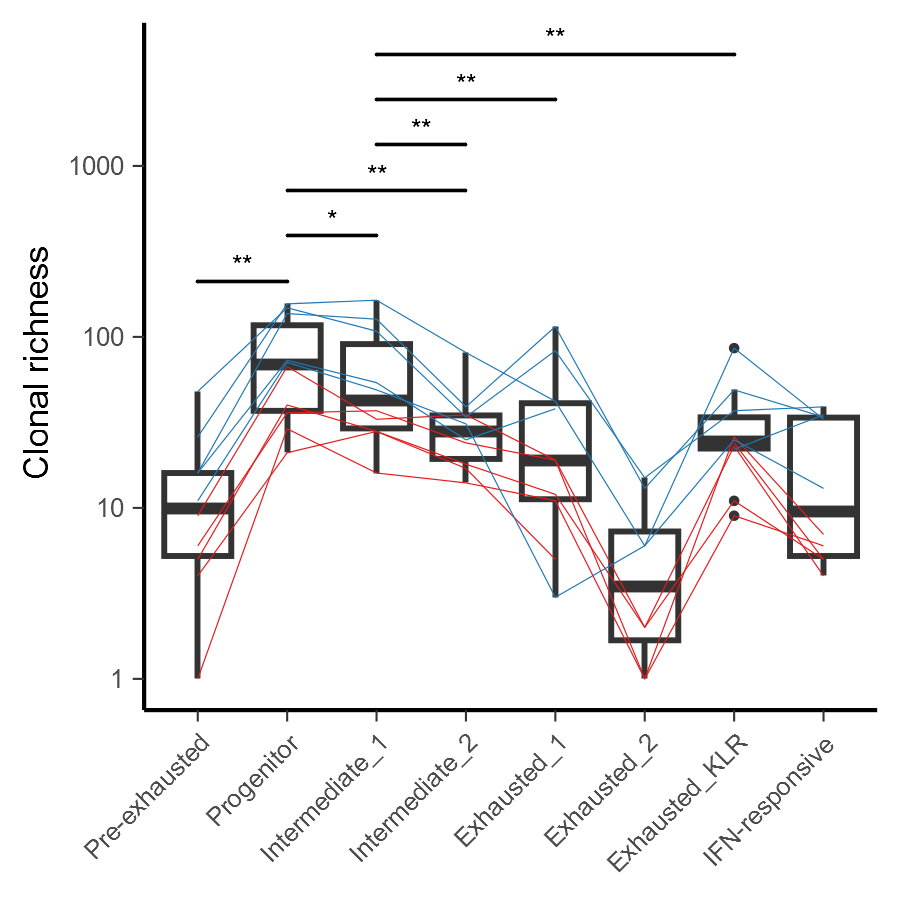

In [28]:
options(repr.plot.width = 3)
seurat$label = factor(seurat$label, levels = levels(seurat$cluster_name)[1:8])
seurat$mouse = paste(seurat$letter, seurat$hash)
df = seurat@meta.data %>% filter(!is.na(clone_id)) %>% group_by(class, mouse, hash, label, clone_id) %>% summarize(n = n()) %>% summarize(div = vegan::diversity(n,base = n()), n = n()) %>%
                                         tidyr::complete(label, fill = list(p = 0))



g1 = ggplot(df, aes(x = label, y = n, group = mouse))  + geom_boxplot(aes(group = NULL), outlier.size = .3) + geom_line(size = .1, aes(color = class)) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                                         stat_compare_means(comparison = list(c(1,2), c(2,3), c(2,4), c(3,4), c(3,5),c(3,7)), paired = TRUE, label = 'p.signif', tip.length = 0) + labs(y = 'Clonal richness') + scale_y_log10() + theme_classic() + 
Axis_themes + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
labs(x = c()) + guides(color = FALSE) + scale_color_manual(values =  brewer.pal(6,'Paired')[c(6,2)])
    


#ggplot(df, aes(x = label, y = div, group = mouse))  + geom_boxplot(aes(group = NULL)) + geom_line() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
#                                         stat_compare_means(comparison = list(c(1,2), c(2,3), c(2,4), c(3,5),c(3,7)), paired = TRUE) + labs(y = 'Clonal diversity') 
    
g1$layers[[3]]$aes_params$textsize <- 2.11
g1
ggsave('TCRfig/pheno_richness.pdf', height = 2.2, width = 2, useDingbats = FALSE)

In [31]:
write.table(df, 'TCRfig/5g.csv', sep = ',')

In [37]:
wilcox.test(n~label, data = df %>% filter(label %in% c('Pre-exhausted', 'Progenitor')), paired = TRUE)
wilcox.test(n~label, data = df %>% filter(label %in% c('Progenitor', 'Intermediate_1')), paired = TRUE)
wilcox.test(n~label, data = df %>% filter(label %in% c('Progenitor', 'Intermediate_2')), paired = TRUE)
wilcox.test(n~label, data = df %>% filter(label %in% c('Intermediate_1', 'Intermediate_2')), paired = TRUE)
wilcox.test(n~label, data = df %>% filter(label %in% c('Intermediate_1', 'Exhausted_1')), paired = TRUE)
wilcox.test(n~label, data = df %>% filter(label %in% c('Intermediate_1', 'Exhausted_KLR')), paired = TRUE)


	Wilcoxon signed rank exact test

data:  n by label
V = 0, p-value = 0.001953
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  n by label
V = 49, p-value = 0.02734
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  n by label
V = 55, p-value = 0.001953
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  n by label
V = 53.5, p-value = 0.009298
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  n by label
V = 55, p-value = 0.005889
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  n by label
V = 55, p-value = 0.005889
alternative hypothesis: true location shift is not equal to 0


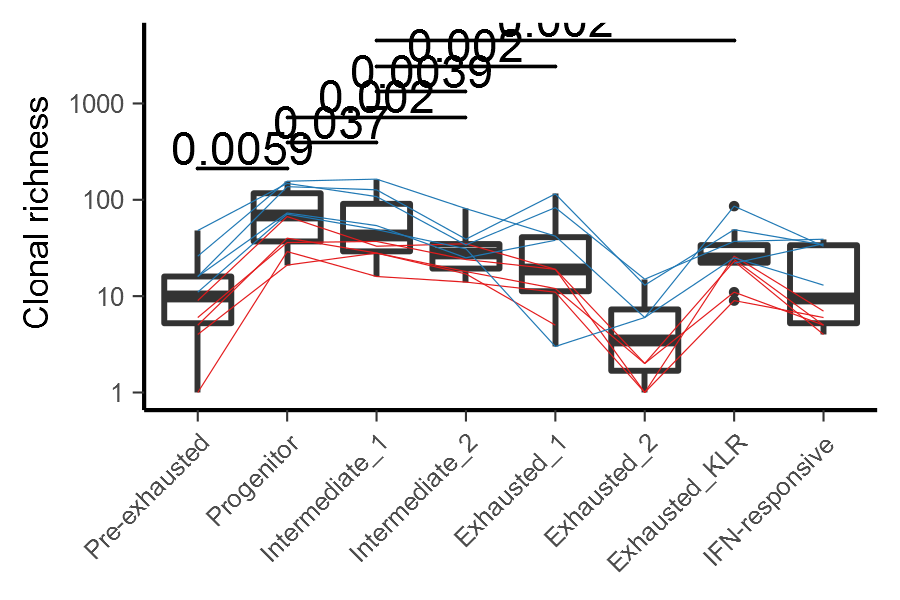

In [130]:
g1 = ggplot(df, aes(x = label, y = n, group = mouse))  + geom_boxplot(aes(group = NULL), outlier.size = .3) + geom_line(size = .1, aes(color = class)) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                                         stat_compare_means(comparison = list(c(1,2), c(2,3), c(2,4), c(3,4), c(3,5),c(3,7)), paired = TRUE, label = 'p.value', tip.length = 0) + labs(y = 'Clonal richness') + scale_y_log10() + theme_classic() + 
Axis_themes + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
labs(x = c()) + guides(color = FALSE) + scale_color_manual(values =  brewer.pal(6,'Paired')[c(6,2)])
    g1

In [38]:
options(repr.plot.width = 6, repr.plot.height = 3)
set.seed(1)
seurat$stem = factor(as.character(sapply(seurat$label, function(x) str_split(x, '_')[[1]][1])), levels = c('Pre-exhausted','Progenitor', 'Intermediate', 'Exhausted', 'IFN-responsive'))
library(reshape2)
tab = table(seurat$clone_id, seurat$label)
tab = tab[rowSums(tab) >2,]
                            
tab[tab == 1] = 0
                                         
tab = tab[rowSums(tab) >0,]
  tab = tab/rowSums(tab)

tab2 =tab           
for (a in 1:nrow(tab2)) {
  vals = tab2[a,]
 vals = vals[order(vals, decreasing = TRUE)]
second = vals[2]
tab2[a, tab[a,] < second] = 0
}
tab2[tab2 != 0] = 1

                                         
clusters = cutree(hclust(dist(tab), method = 'complete'), k = 11)
                                         
meta = data.frame(row.names = rownames(tab), letter = substring(rownames(tab), 1, 1))
key = c('Control', 'ICB')
names(key) = c('C', 'P')
meta$letter = key[meta$letter]
meta$states = apply(tab2, 1, function(x) paste(names(which(x >  0)), collapse = '->'))
meta$states[str_length(meta$states) > 30] = 'Three fates'
        
                    
meta$states = factor(meta$states, levels = c('Pre-exhausted','Progenitor', 'Progenitor->Intermediate_1', 'Progenitor->Intermediate_2','Intermediate_1', 'Intermediate_2','Intermediate_1->Intermediate_2', 'Intermediate_1->Exhausted_1', 
                                                                    'Intermediate_1->Exhausted_KLR', 'Exhausted_1', 'Exhausted_KLR', 'Three fates', 'Other pair'))
meta$states[is.na(meta$states)] = 'Other pair'
#keep =table(meta$states)
#keep = names(keep[keep > 2])
#meta$states[rowSums(tab2 >0) > 3] = NA
                    
#meta$states[!meta$states %in% keep] = NA
cbt_palette = brewer.pal(6,'Paired')[c(6,2)]
names(cbt_palette) =c('Control', 'ICB')
                    
transition_palette =c(ggthemes_data[['tableau']][['color-palettes']]$regular$`Tableau 20`$value[1:11], 'grey50', 'grey80')
names(transition_palette) = levels(factor(unique(meta$states)))

tab = tab[sample(rownames(tab), 150),]                    
dgram = hclust(dist(tab))
clusts = factor(cutree(dgram, 12))

wts = apply(tab, 1, function(x) which.max(x)^2*max(x) -1*which.max(x[x!=max(x)]))
pheatmap(tab %>% t(),#[reorder(dgram, wts = wts, agglo.FUN = 'mean')$order,] %>% t() 
         , show_colnames = FALSE, cluster_rows = FALSE, cluster_cols = reorder(dgram, wts = wts, agglo.FUN = 'mean'), annotation_col = meta, fontsize = 6, color = colorRampPalette(c('white', 'dodgerblue3'))(100), 
        annotation_color = list(letter = cbt_palette, states = transition_palette), angle_col = 45, border_color = 'grey85',treeheight_col = 2
        ,filename = 'TCRfig/cloneheat.pdf', height = 2.5, width = 8)
               


In [42]:
tab = table(seurat$clone_id, seurat$label)
tab = tab[rowSums(tab) >2,]
                            
#tab[tab == 1] = 0
                                         
tab = tab/rowSums(tab)

tab2 =tab           
for (a in 1:nrow(tab2)) {
  vals = tab2[a,]
 vals = vals[order(vals, decreasing = TRUE)]
second = vals[2]
tab2[a, tab[a,] < second] = 0
}
#tab2[tab2 != 0] = 1

                                         
meta = data.frame(row.names = rownames(tab), letter = substring(rownames(tab), 1, 1))
key = c('Control', 'ICB')
names(key) = c('C', 'P')
meta$letter = key[meta$letter]
meta$states = apply(tab2, 1, function(x) paste(names(which(x >  0)), collapse = '->'))
meta$states[str_length(meta$states) > 30] = 'Three fates'
        
                    
meta$states = factor(meta$states, levels = c('Pre-exhausted','Progenitor', 'Progenitor->Intermediate_1', 'Progenitor->Intermediate_2','Intermediate_1', 'Intermediate_2','Intermediate_1->Intermediate_2', 'Intermediate_1->Exhausted_1', 
                                                                    'Intermediate_1->Exhausted_KLR', 'Exhausted_1', 'Exhausted_KLR', 'Three fates', 'Other pair'))
meta$states[is.na(meta$states)] = 'Other pair'

                    
                    
                    
seurat$clone_trajectory = meta[seurat$clone_id, 'states']
seurat$clone_trajectory = factor(seurat$clone_trajectory, levels = c('Progenitor', 'Progenitor->Intermediate_1', 'Progenitor->Intermediate_2','Intermediate_1', 'Intermediate_2','Intermediate_1->Intermediate_2', 'Intermediate_1->Exhausted_1', 
                                                                    'Intermediate_1->Exhausted_KLR', 'Exhausted_1', 'Exhausted_KLR','Three fates', 'Other pair'))



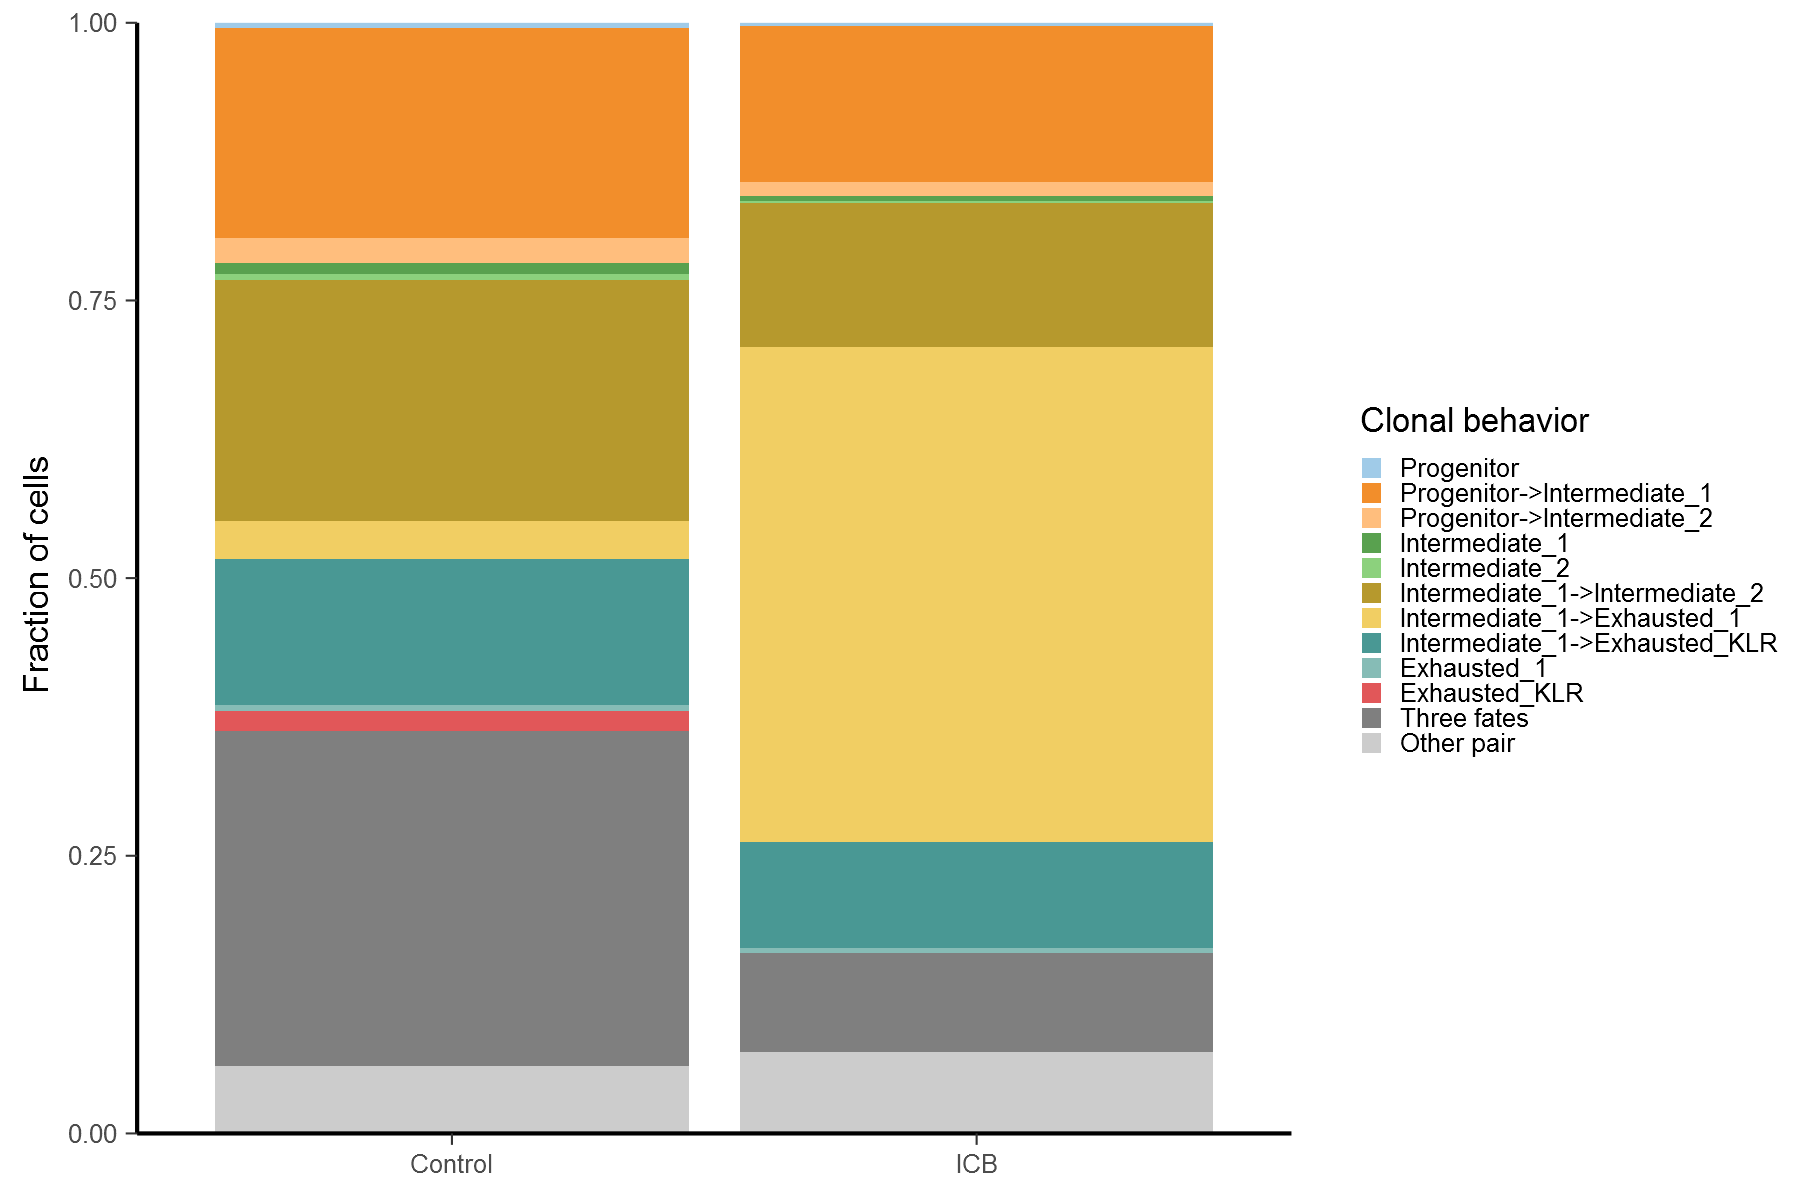

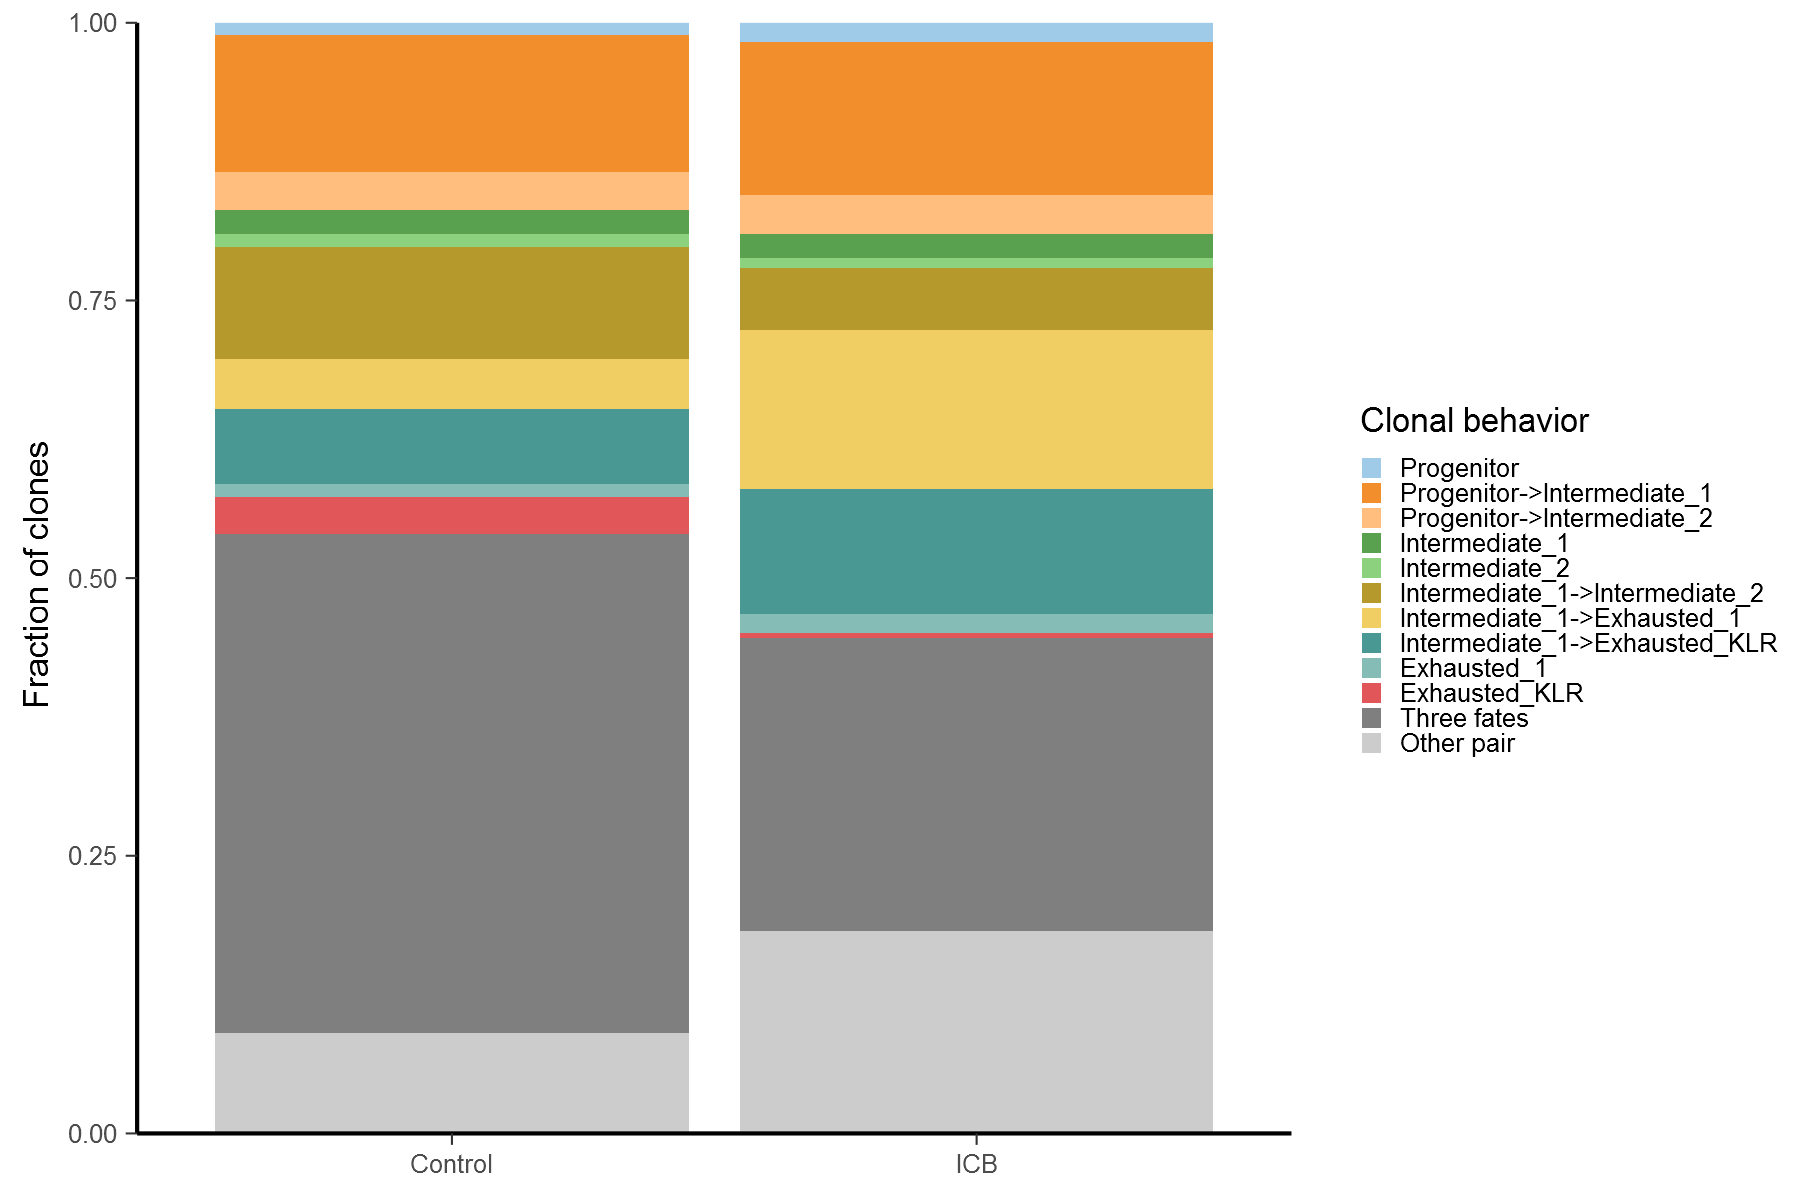

In [43]:
options(repr.plot.height = 4)
df = seurat@meta.data %>% filter(clonal_size > 2) %>% group_by(clone_id) #%>% slice(1)

#df$clone_trajectory = gsub(df$clone_trajectory, pattern = '>', replacement = '\n\t->')
ggplot(df, aes(x = class, fill = clone_trajectory)) + geom_bar(position= 'fill') + scale_fill_manual(values = transition_palette, na.value = 'white') + theme_classic() + Axis_themes + 
scale_y_continuous(expand = c(0,0)) + labs(x = c(), y = 'Fraction of cells') + labs(fill = 'Clonal behavior') + 
theme(legend.key.size = unit(.2, 'cm'))
ggsave('TCRfig/stackedbar_clones.pdf', height = 2.2, width = 2.8, useDingbats = FALSE)



df = seurat@meta.data %>% filter(clonal_size > 2) %>% group_by(clone_id) %>% slice(1)
ggplot(df, aes(x = class, fill = clone_trajectory)) + geom_bar(position= 'fill') + scale_fill_manual(values = transition_palette, na.value = 'white') + theme_classic() + Axis_themes + 
scale_y_continuous(expand = c(0,0)) + labs(x = c(), y = 'Fraction of clones') + labs(fill = 'Clonal behavior') + theme(legend.key.size = unit(.2, 'cm'))
ggsave('TCRfig/stackedbar_clonesweighted.pdf', height = 2.2, width = 2.8, useDingbats = FALSE)


`summarise()` has grouped output by 'class', 'hash', 'clone_trajectory', 'tot'. You can override using the `.groups` argument.


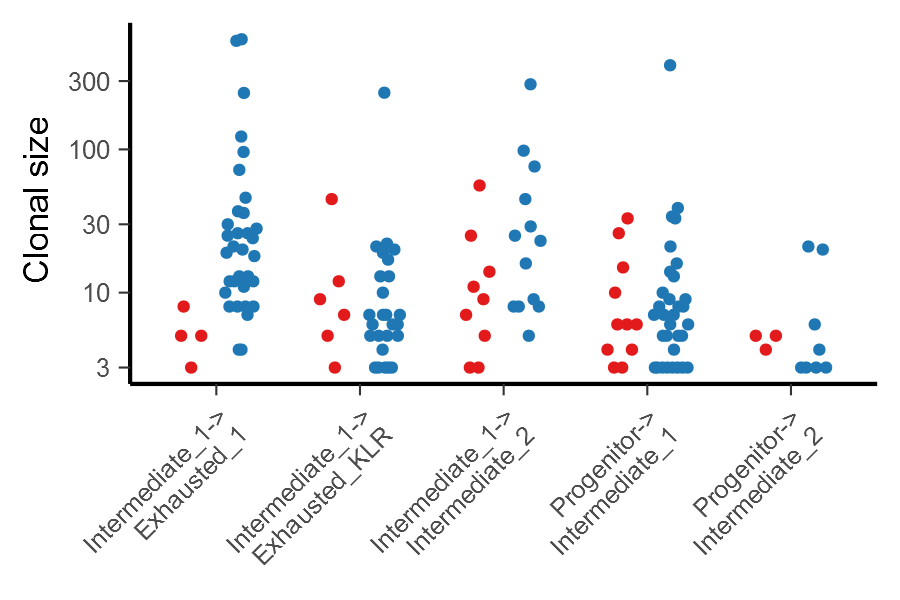

In [44]:
options(repr.plot.width = 3, repr.plot.height = 2)
df = seurat@meta.data %>% filter(!is.na(clone_id), !is.na(clone_trajectory), clonal_size > 1, str_length(clone_trajectory) > 15) %>% group_by(class, hash) %>% mutate(tot = n()) %>% group_by(class, hash, clone_trajectory, tot, clone_id) %>% 
summarize(n = n()) %>% mutate(frac = n/tot)

df$label_space = gsub(df$clone_trajectory, pattern = '->', replacement = '->\n')
g1 =ggplot(df, aes(x = label_space, y = n,color =class, group = class)) +
geom_quasirandom(dodge.width = .7, size = .5) + 
scale_y_log10() + theme_classic() + 
Axis_themes + labs(x = c()) + scale_color_manual(values = cbt_palette) + guides(color = FALSE) + labs(y = 'Clonal size') + theme(strip.background = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1))

g1$layers[[1]]$aes_params$textsize <- 2.11
g1
#ggplot(df, aes(x = class, fill = clone_trajectory)) + geom_bar(position= 'fill')
ggsave('TCRfig/clone_size.pdf', height = 2.2, width = 2.3, useDingbats = FALSE)

In [47]:
write.table(df, 'TCRfig/5h.csv', sep = ',')

In [62]:
options(repr.plot.width = 2.5, repr.plot.height = 2.3)
tab = table(seurat$clone_id, seurat$label)
tab = tab[rowSums(tab) >2,]
tab[tab == 1] = 0
                                         
second = apply(tab, 1, function(x) quantile(x, .75))
tab = tab[rowSums(tab) >2,]
  tab = tab/rowSums(tab)
mat = matrix(0, ncol(tab), ncol(tab))
for (a in 1:nrow(mat)) {
    for (b in 1:nrow(mat)) {
        col1 = tab[,a]
        col2 = tab[,b]
        mat[a, b] = sum(col1* col2) / sqrt(sum(col1)*sum(col2))
        if (a == b) {
            mat[a,b] = NA
        }
        if (a %in% c(1) & b  > 1) {
            mat[a,b] = NA
        }
        if (a %in% c(2) & b > 2){
            mat[a,b] = NA
            }

        if (a %in% c(3) & b  > 4) {
            mat[a,b] = NA
        }
        if (a %in% c(4) & b  > 4) {
            mat[a,b] = NA
        }
        if (a %in% c(5,6,7) & b > 7) {
            mat[a,b] = NA
        }
    }
}
rownames(mat) = colnames(tab)
colnames(mat) = colnames(tab)
mat
#mat = t(mat)
#mat = scale(mat)
#mat = t(mat)
pheatmap(mat, cluster_rows = FALSE, cluster_cols = FALSE, fontsize = 6, color =colorRampPalette(brewer.pal( 10,'Reds'))(100), na_col= 'grey', angle_col = 90, border_color = 'black', cellwidth = 10, cellheight = 10, 
        filename = 'TCRfig/transition.pdf')

,Pre-exhausted,Progenitor,Intermediate_1,Intermediate_2,Exhausted_1,Exhausted_2,Exhausted_KLR,IFN-responsive
Pre-exhausted,NA,NA,NA,NA,NA,NA,NA,NA
Progenitor,0.062426950,NA,NA,NA,NA,NA,NA,NA
Intermediate_1,0.094134800,0.145430104,NA,0.1044325217,NA,NA,NA,NA
Intermediate_2,0.046679850,0.080935581,0.10443252,NA,NA,NA,NA,NA
Exhausted_1,0.042603727,0.068501849,0.13260979,0.0364716927,NA,0.024652664,0.060214504,NA
Exhausted_2,0.007960048,0.005620712,0.01822221,0.0003861996,0.02465266,NA,0.002692369,NA
Exhausted_KLR,0.012173702,0.052209259,0.12696578,0.0375256900,0.06021450,0.002692369,NA,NA
IFN-responsive,0.008798321,0.027596511,0.02912513,0.0180274771,0.03419856,0.001267836,0.003276400,NA


`summarise()` has grouped output by 'class', 'hash', 'clone_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'hash', 'tissue'. You can override using the `.groups` argument.


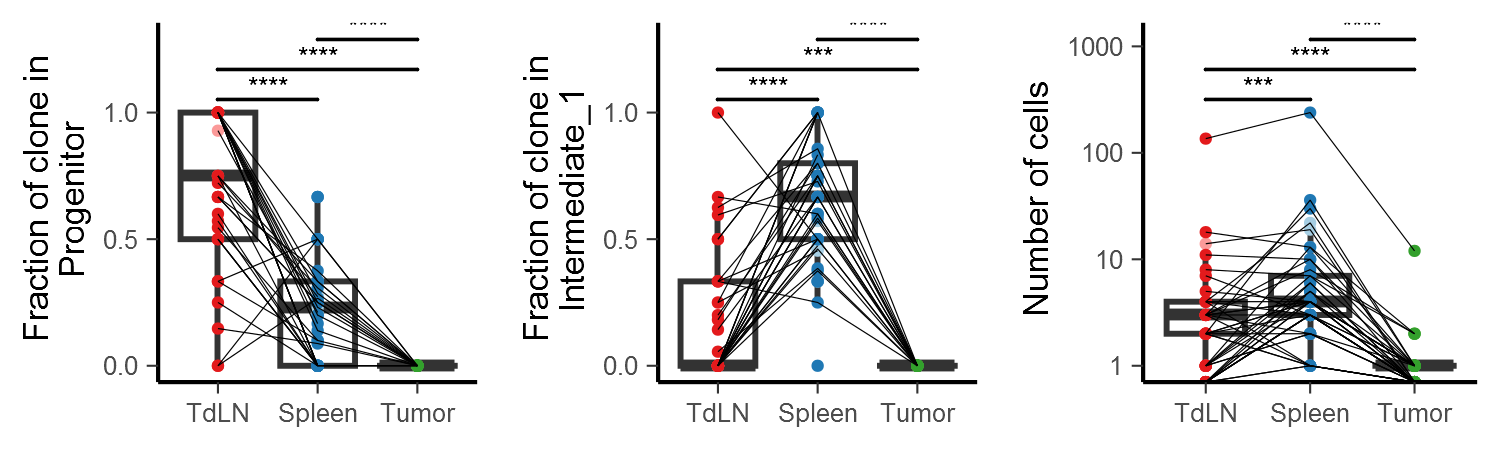

In [63]:
options(repr.plot.width = 5, repr.plot.height = 1.5)
tissue_palette = brewer.pal(10, 'Paired')[c(5,1,3,6,2,4)]

names(tissue_palette) = c('Control_TdLN', 'Control_Spleen', 'Control_Tumor', 'ICB_TdLN', 'ICB_Spleen', 'ICB_Tumor')

fate1 = 'Progenitor'
fate2 = 'Intermediate_1'
df = seurat@meta.data %>% filter(clone_trajectory == paste0(fate1, '->', fate2)) %>% group_by(class,  hash, clone_id, tissue) %>%
summarize(frac_progenitor = sum(label == fate1)/n(), frac_int1 = sum(label == fate2)/n(), n = n()) %>% tidyr::complete(tissue, fill = list(n =0))
df$both = paste0(df$class, '_', df$tissue)

df2 = df %>% group_by(both, class,  hash, tissue, clone_id) %>% summarize(n = sum(n))


plabel = 'p.signif'
g1 = ggplot(df, aes(x = tissue, y = frac_progenitor)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate1)) + guides(color = FALSE) + theme_classic() + Axis_themes + scale_color_manual(values = tissue_palette)




g2 = ggplot(df, aes(x = tissue, y = frac_int1)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label =plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate2))+ guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)

g3 =ggplot(df2, aes(x = tissue, y = n))+ geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) +
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)   + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) + scale_y_log10()+ guides(fill = FALSE) + theme_classic()   + 
Axis_themes + labs(x = c(), y='Number of cells') + guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)
g1$layers[[4]]$aes_params$textsize <- 2.11
g2$layers[[4]]$aes_params$textsize <- 2.11
g3$layers[[4]]$aes_params$textsize <- 2.11


cowplot::plot_grid(g1, g2, g3, ncol = 3)
ggsave('TCRfig/pro-int1.pdf', useDingbats = FALSE, height = 3.9/3, width = 4.67)
plot2 = cowplot::plot_grid(g1, g2, g3, ncol = 3)


In [65]:
dim(df2)

[1] 135   6

`summarise()` has grouped output by 'class', 'hash', 'clone_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'hash', 'tissue'. You can override using the `.groups` argument.


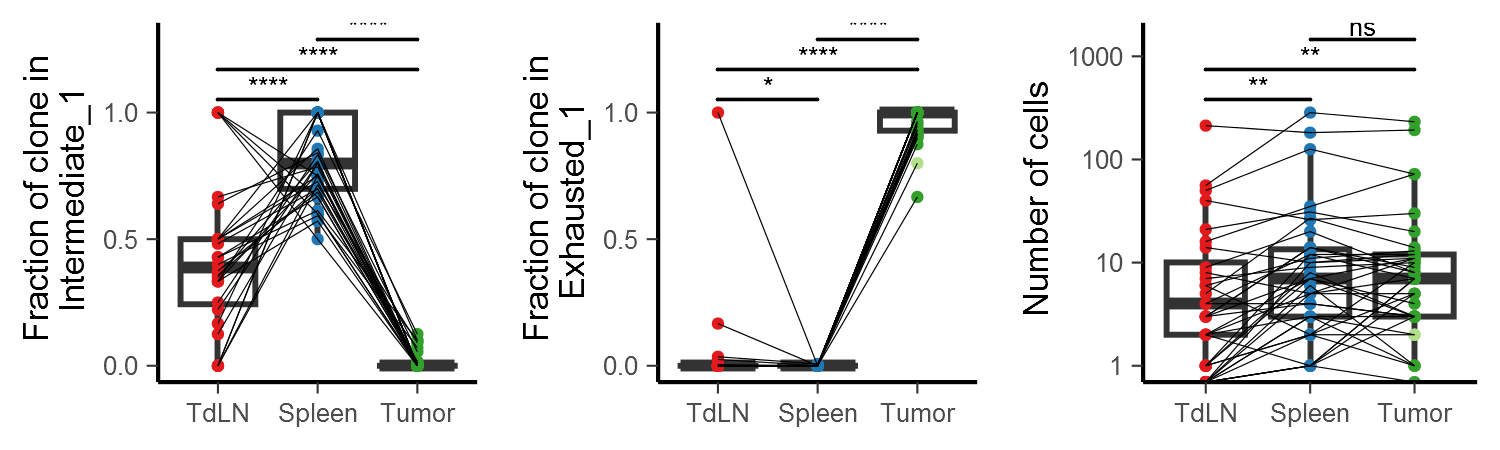

In [66]:
options(repr.plot.width = 5, repr.plot.height = 1.5)
tissue_palette = brewer.pal(10, 'Paired')[c(5,1,3,6,2,4)]

names(tissue_palette) = c('Control_TdLN', 'Control_Spleen', 'Control_Tumor', 'ICB_TdLN', 'ICB_Spleen', 'ICB_Tumor')

fate1 = 'Intermediate_1'
fate2 = 'Exhausted_1'
df = seurat@meta.data %>% filter(clone_trajectory == paste0(fate1, '->', fate2)) %>% group_by(class,  hash, clone_id, tissue) %>%
summarize(frac_progenitor = sum(label == fate1)/n(), frac_int1 = sum(label == fate2)/n(), n = n()) %>% tidyr::complete(tissue, fill = list(n =0))
df$both = paste0(df$class, '_', df$tissue)

df2 = df %>% group_by(both, class,  hash, tissue, clone_id) %>% summarize(n = sum(n))



g1 = ggplot(df, aes(x = tissue, y = frac_progenitor)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate1)) + guides(color = FALSE) + theme_classic() + Axis_themes + scale_color_manual(values = tissue_palette)




g2 = ggplot(df, aes(x = tissue, y = frac_int1)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate2))+ guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)

g3 =ggplot(df2, aes(x = tissue, y = n))+ geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)   + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) + scale_y_log10()+ guides(fill = FALSE) + theme_classic()   + 
Axis_themes + labs(x = c(), y='Number of cells') + guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)
g1$layers[[4]]$aes_params$textsize <- 2.11
g2$layers[[4]]$aes_params$textsize <- 2.11
g3$layers[[4]]$aes_params$textsize <- 2.11


cowplot::plot_grid(g1, g2, g3, ncol = 3)
ggsave('TCRfig/int1-exh1.pdf', useDingbats = FALSE, height = 3.9/3, width = 4.67)
plot3 = cowplot::plot_grid(g1, g2, g3, ncol = 3)


In [68]:
dim(df)

[1] 114   8

`summarise()` has grouped output by 'class', 'hash', 'clone_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'hash', 'tissue'. You can override using the `.groups` argument.


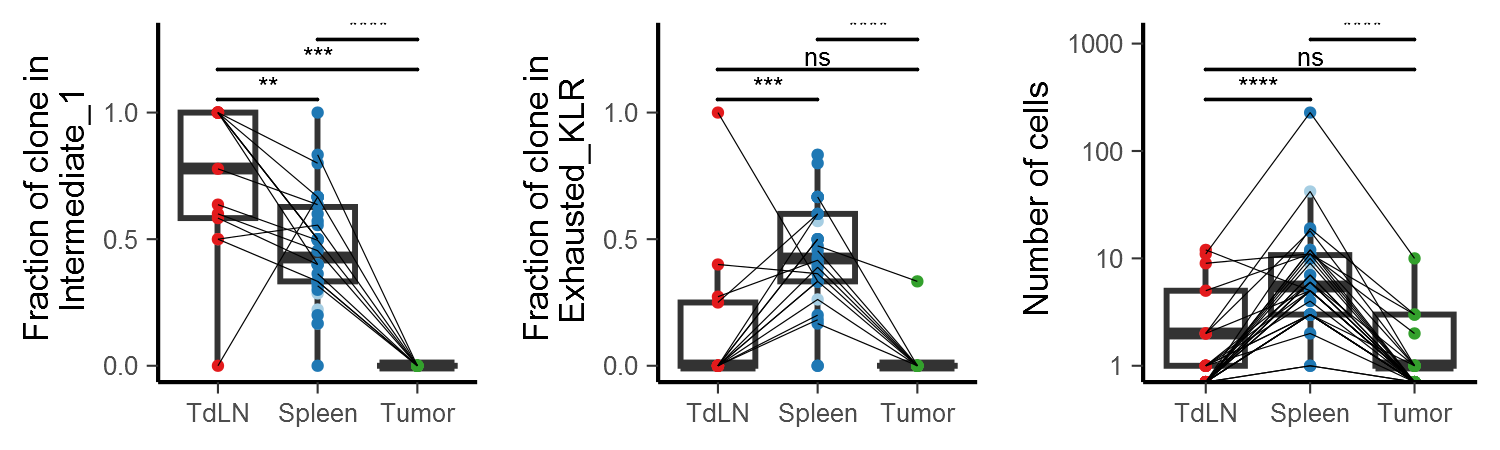

In [69]:
options(repr.plot.width = 5, repr.plot.height = 1.5)
tissue_palette = brewer.pal(10, 'Paired')[c(5,1,3,6,2,4)]

names(tissue_palette) = c('Control_TdLN', 'Control_Spleen', 'Control_Tumor', 'ICB_TdLN', 'ICB_Spleen', 'ICB_Tumor')

fate1 = 'Intermediate_1'
fate2 = 'Exhausted_KLR'
df = seurat@meta.data %>% filter(clone_trajectory == paste0(fate1, '->', fate2)) %>% group_by(class,  hash, clone_id, tissue) %>%
summarize(frac_progenitor = sum(label == fate1)/n(), frac_int1 = sum(label == fate2)/n(), n = n()) %>% tidyr::complete(tissue, fill = list(n =0))
df$both = paste0(df$class, '_', df$tissue)

df2 = df %>% group_by(both, class,  hash, tissue, clone_id) %>% summarize(n = sum(n))



g1 = ggplot(df, aes(x = tissue, y = frac_progenitor)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate1)) + guides(color = FALSE) + theme_classic() + Axis_themes + scale_color_manual(values = tissue_palette)




g2 = ggplot(df, aes(x = tissue, y = frac_int1)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate2))+ guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)

g3 =ggplot(df2, aes(x = tissue, y = n))+ geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)   + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = 'p.signif', tip.length = 0) + scale_y_log10()+ guides(fill = FALSE) + theme_classic()   + 
Axis_themes + labs(x = c(), y='Number of cells') + guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)
g1$layers[[4]]$aes_params$textsize <- 2.11
g2$layers[[4]]$aes_params$textsize <- 2.11
g3$layers[[4]]$aes_params$textsize <- 2.11


cowplot::plot_grid(g1, g2, g3, ncol = 3)
ggsave('TCRfig/int1-exhklr.pdf', useDingbats = FALSE, height = 3.9/3, width = 4.67)
plot4 = cowplot::plot_grid(g1, g2, g3, ncol = 3)


In [70]:
dim(df2)

[1] 102   6

In [99]:
6.5/3*4

[1] 8.666667

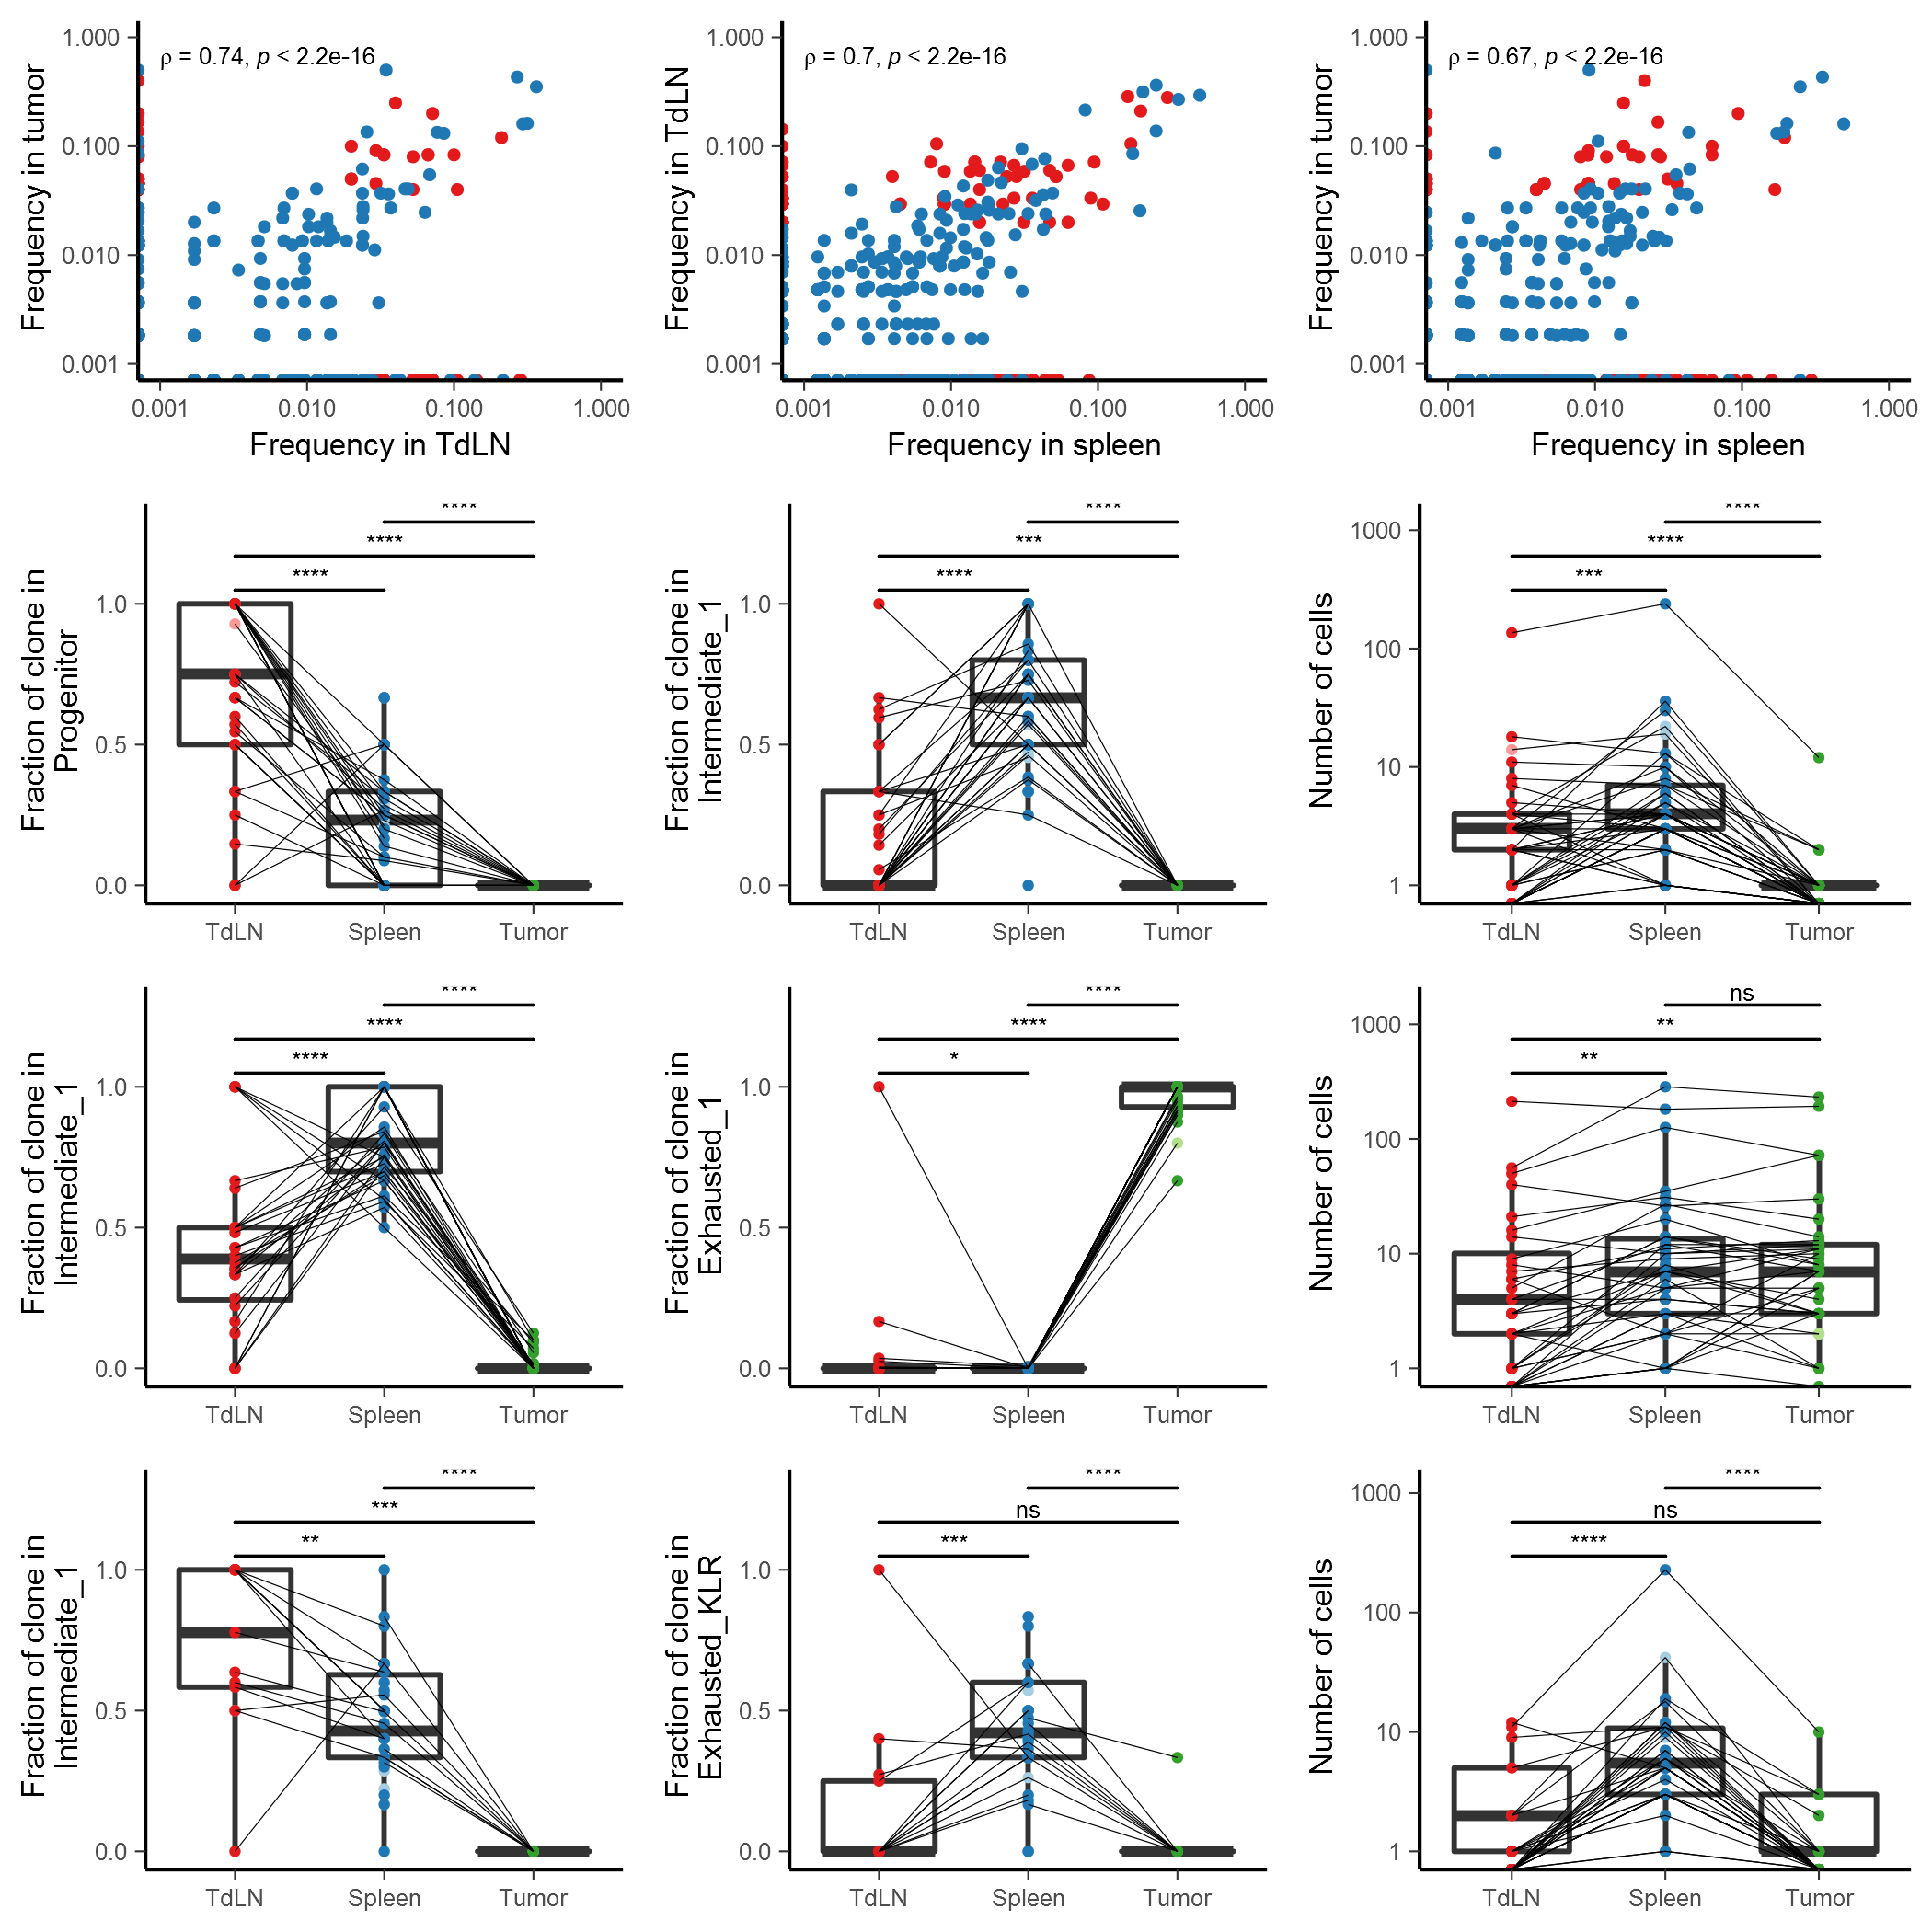

In [104]:
options(repr.plot.width = 7, repr.plot.height = 7)

cowplot::plot_grid(plot1, plot2, plot3, plot4, ncol = 1)
ggsave('TCRfig/12plot.pdf', width =7, height = 5/3*4, useDingbats = FALSE)

`summarise()` has grouped output by 'class', 'hash', 'clone_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'hash', 'tissue'. You can override using the `.groups` argument.


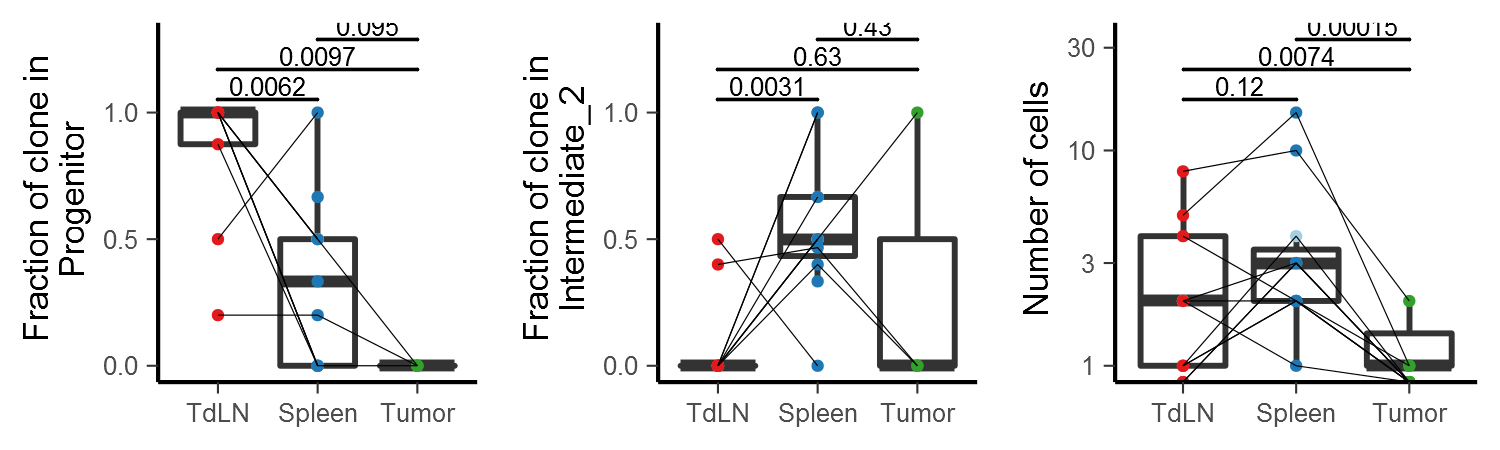

In [153]:
options(repr.plot.width = 5, repr.plot.height = 1.5)
tissue_palette = brewer.pal(10, 'Paired')[c(5,1,3,6,2,4)]

names(tissue_palette) = c('Control_TdLN', 'Control_Spleen', 'Control_Tumor', 'ICB_TdLN', 'ICB_Spleen', 'ICB_Tumor')

fate1 = 'Progenitor'
fate2 = 'Intermediate_2'
df = seurat@meta.data %>% filter(clone_trajectory == paste0(fate1, '->', fate2)) %>% group_by(class,  hash, clone_id, tissue) %>%
summarize(frac_progenitor = sum(label == fate1)/n(), frac_int1 = sum(label == fate2)/n(), n = n()) %>% tidyr::complete(tissue, fill = list(n =0))
df$both = paste0(df$class, '_', df$tissue)

df2 = df %>% group_by(both, class,  hash, tissue, clone_id) %>% summarize(n = sum(n))


plabel = 'p.label'
g1 = ggplot(df, aes(x = tissue, y = frac_progenitor)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate1)) + guides(color = FALSE) + theme_classic() + Axis_themes + scale_color_manual(values = tissue_palette)




g2 = ggplot(df, aes(x = tissue, y = frac_int1)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label =plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate2))+ guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)

g3 =ggplot(df2, aes(x = tissue, y = n))+ geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) +
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)   + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) + scale_y_log10()+ guides(fill = FALSE) + theme_classic()   + 
Axis_themes + labs(x = c(), y='Number of cells') + guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)
g1$layers[[4]]$aes_params$textsize <- 2.11
g2$layers[[4]]$aes_params$textsize <- 2.11
g3$layers[[4]]$aes_params$textsize <- 2.11


cowplot::plot_grid(g1, g2, g3, ncol = 3)
plot5 = cowplot::plot_grid(g1, g2, g3, ncol = 3)


`summarise()` has grouped output by 'class', 'hash', 'clone_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'hash', 'tissue'. You can override using the `.groups` argument.


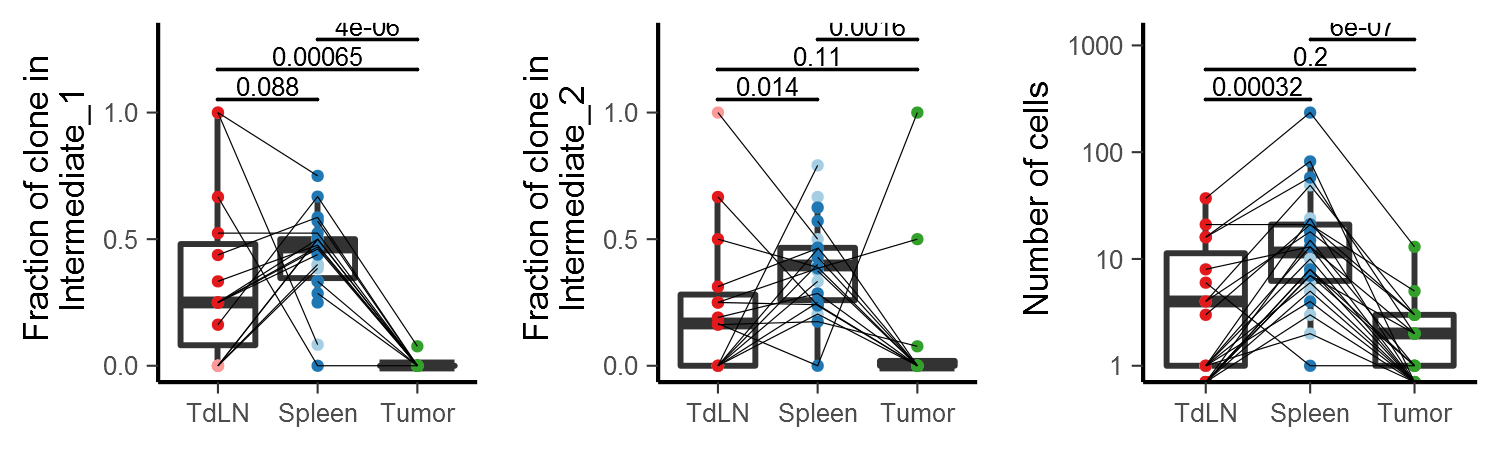

In [152]:
options(repr.plot.width = 5, repr.plot.height = 1.5)
tissue_palette = brewer.pal(10, 'Paired')[c(5,1,3,6,2,4)]

names(tissue_palette) = c('Control_TdLN', 'Control_Spleen', 'Control_Tumor', 'ICB_TdLN', 'ICB_Spleen', 'ICB_Tumor')

fate1 = 'Intermediate_1'
fate2 = 'Intermediate_2'
df = seurat@meta.data %>% filter(clone_trajectory == paste0(fate1, '->', fate2)) %>% group_by(class,  hash, clone_id, tissue) %>%
summarize(frac_progenitor = sum(label == fate1)/n(), frac_int1 = sum(label == fate2)/n(), n = n()) %>% tidyr::complete(tissue, fill = list(n =0))
df$both = paste0(df$class, '_', df$tissue)

df2 = df %>% group_by(both, class,  hash, tissue, clone_id) %>% summarize(n = sum(n))


plabel = 'p.label'
g1 = ggplot(df, aes(x = tissue, y = frac_progenitor)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate1)) + guides(color = FALSE) + theme_classic() + Axis_themes + scale_color_manual(values = tissue_palette)




g2 = ggplot(df, aes(x = tissue, y = frac_int1)) + geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) + 
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)  + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label =plabel, tip.length = 0) +
labs(x = c(), y= paste0('Fraction of clone in\n', fate2))+ guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)

g3 =ggplot(df2, aes(x = tissue, y = n))+ geom_boxplot(outlier.size = 0) + geom_point(aes(color = both), size= .5) +
geom_line(color = 'black',aes(group = clone_id, color = class), size = .1)   + stat_compare_means(comparison = list(c(1,2), c(1,3), c(2,3)), label = plabel, tip.length = 0) + scale_y_log10()+ guides(fill = FALSE) + theme_classic()   + 
Axis_themes + labs(x = c(), y='Number of cells') + guides(color = FALSE) + theme_classic() + Axis_themes+ scale_color_manual(values = tissue_palette)
g1$layers[[4]]$aes_params$textsize <- 2.11
g2$layers[[4]]$aes_params$textsize <- 2.11
g3$layers[[4]]$aes_params$textsize <- 2.11


cowplot::plot_grid(g1, g2, g3, ncol = 3)
plot6 = cowplot::plot_grid(g1, g2, g3, ncol = 3)


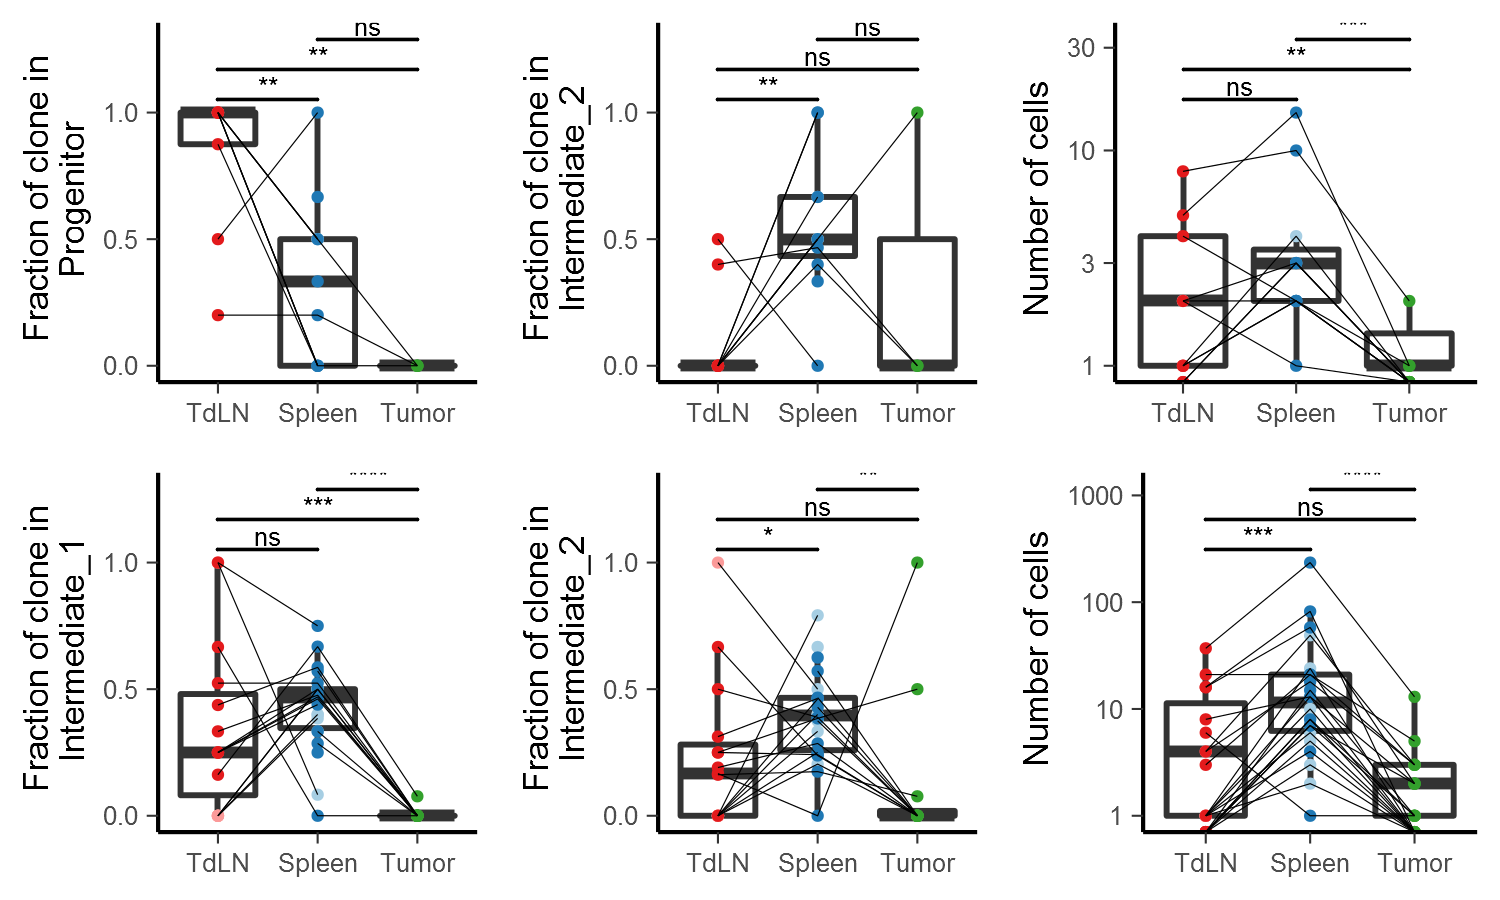

In [151]:
options(repr.plot.width = 5, repr.plot.height = 3)

cowplot::plot_grid(plot5, plot6, ncol = 1)
ggsave('TCRfig/supp_transitions.pdf', height = 3.5, width = 7, useDingbats = FALSE)

In [21]:
df = seurat@meta.data %>% filter(!is.na(clone_id)) %>% group_by(class, hash, tissue, clone_id) %>% summarize(n = n()) %>% mutate(p =n/sum(n))

In [218]:
save.image('2023_01_09_clonotype.RDATA')

In [1]:
load('2023_01_09_clonotype.RDATA')

In [2]:
saveRDS(seurat, 'final_seurat.RDS')